In [6]:
import os.path as osp
import pandas as pd
import numpy as np

from glob import glob
import sys
import importlib as imp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import json
import pickle as pc
from sklearn.feature_extraction import DictVectorizer


## Features

In [4]:
X_file = '../../external/transcendent/extended-features-X.json'
y_file = '../../external/transcendent/extended-features-y.json'
meta_file = '../../external/transcendent/extended-features-meta.json'

# vectorizer = DictVectorizer(sparse=True, dtype=int)
# with open(X_file, 'r') as infile:
#     X=json.load(infile)
#     X_t = vectorizer.fit_transform(X)
    
# with open(y_file, 'r') as infile:
#     y=json.load(infile)
#     y = np.array(y)
    
with open(meta_file, 'r') as infile:
    meta=json.load(infile)
    meta_df = pd.DataFrame(meta)
    

In [8]:
# type(X), X[0].keys()
market_counts = meta_df.markets.value_counts().sort_values(ascending=False)
np.unique(y, return_counts=True)
meta_df[['markets', 'vt_detection']].head()

,markets,vt_detection
0,anzhi,0.0
1,play.google.com,0.0
2,play.google.com,0.0
3,play.google.com,0.0
4,play.google.com,0.0


In [9]:
# TESTS - NO COMMON FEATURES
# # Find the common features
# common_features = set(X[0].keys())
# for data in X[1:]:
#     common_features |= data.keys()

# # Print the common features
# print(len(common_features))

In [10]:
# X_vec = []
# for data_point in X:
#     features = {}
#     for feature_name, feature_value in data_point.items():
#         # Convert the feature to binary representation (e.g., 0 or 1)
#         features[feature_name] = int(feature_value is not None)

#     X_vec.append(features)
# X_t = vectorizer.fit_transform(X_vec)


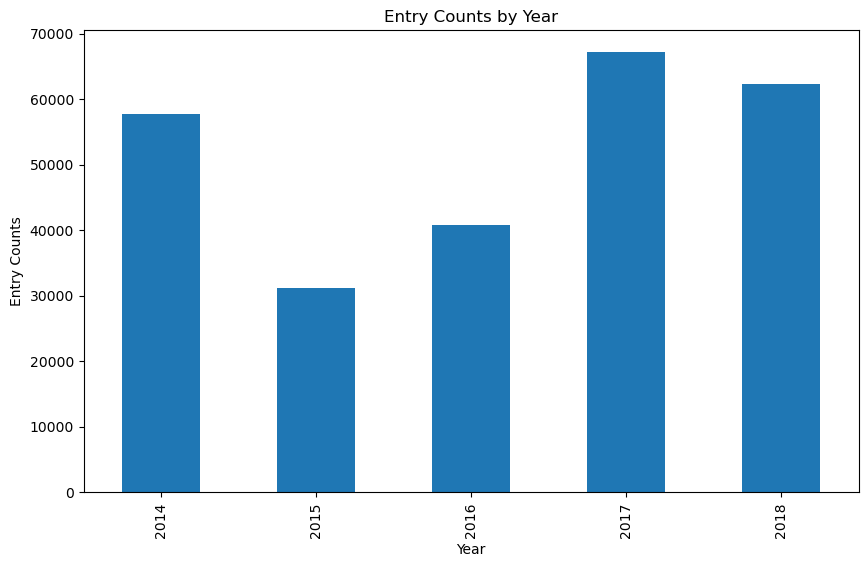

In [11]:
meta_df['dex_date'] = pd.to_datetime(meta_df['dex_date'])
meta_df['year2'] = meta_df['dex_date'].dt.year

def bar_chart(counts_by_column):
    plt.figure(figsize=(10, 6))
    counts_by_column.plot(kind='bar')
    plt.xlabel('Year')
    plt.ylabel('Entry Counts')
    plt.title('Entry Counts by Year')
    plt.show()

counts_by_year = meta_df.groupby('year2').size()
bar_chart(counts_by_year)

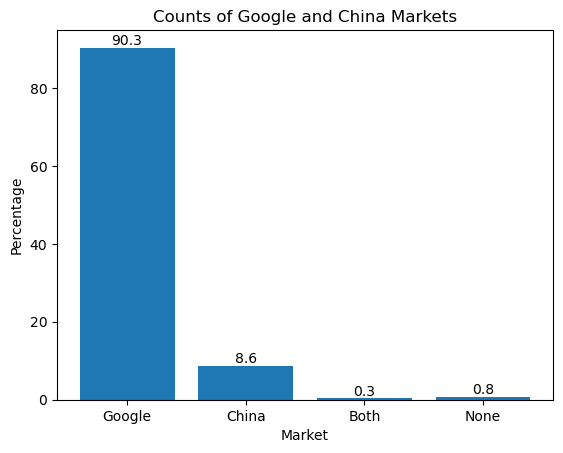

In [12]:
market_counts = meta_df.markets.value_counts().sort_values(ascending=False)
meta_df['google'] = meta_df.markets.str.contains('play.google.com')
meta_df['china'] = (meta_df.markets.str.contains('appchina') | meta_df.markets.str.contains('anzhi'))
count_google = ((meta_df['google'] == 1) & (meta_df['china'] == 0)).sum() * 100 / len(meta_df)
count_china = ((meta_df['google'] == 0) & (meta_df['china'] == 1)).sum() * 100 / len(meta_df)
count_both = ((meta_df['google'] == 1) & (meta_df['china'] == 1)).sum() * 100 / len(meta_df)
count_none = ((meta_df['google'] == 0) & (meta_df['china'] == 0)).sum() * 100 / len(meta_df)

markets = ['Google', 'China', 'Both', 'None']
counts = [count_google, count_china, count_both, count_none]
bars = plt.bar(markets, counts)

for bar in bars:
    height = round(bar.get_height(), 1)
    plt.text(bar.get_x() + bar.get_width() / 2, height, height,
             ha='center', va='bottom')
    
plt.xlabel('Market')
plt.ylabel('Percentage')
plt.title('Counts of Google and China Markets')
plt.show()

In [13]:
ben_train = meta_df[(meta_df['google'] == 1) & (meta_df['china'] == 0) & (meta_df.vt_detection == 0) & (meta_df['year2']<2016)].sample(n=8000, random_state=42).index
mal_train1 = meta_df[(meta_df['google'] == 1) & (meta_df['china'] == 0) & (meta_df.vt_detection >=10) & (meta_df['year2']<2016)].sample(n=800, random_state=42).index
mal_train2 = meta_df[(meta_df['google'] == 0) & (meta_df['china'] == 1) & (meta_df.vt_detection >=10) & (meta_df['year2']<2016)].sample(n=800, random_state=42).index
ben_test = meta_df[(meta_df['google'] == 1) & (meta_df['china'] == 0) & (meta_df.vt_detection == 0) & (meta_df['year2']>=2016)].sample(n=2000, random_state=42).index
mal_test1 = meta_df[(meta_df['google'] == 1) & (meta_df['china'] == 0) & (meta_df.vt_detection >= 10) & (meta_df['year2']>=2016)].sample(n=200, random_state=42).index
mal_test2 = meta_df[(meta_df['google'] == 0) & (meta_df['china'] == 1) & (meta_df.vt_detection >= 10) & (meta_df['year2']>=2016)].sample(n=200, random_state=42).index
d1_train = np.concatenate([ben_train, mal_train1])
d1_test = np.concatenate([ben_test, mal_test1])
d2_train = np.concatenate([ben_train, mal_train2])
d2_test = np.concatenate([ben_test, mal_test2])


In [14]:
d_u = meta_df[((meta_df['google'] == 1) | (meta_df['china'] == 1)) & (meta_df['year2'] >= 2016)].index

used_4test = set(np.concatenate([d1_test, d2_test]))
d_u = np.array(list(set(d_u) - used_4test))


In [15]:
pc.dump((d1_train, d1_test, d2_train, d2_test, d_u), open('all_indices.pkl', 'wb'))